1. FETCHING DATA WITH NEWS API

In [66]:
pip install requests


Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install newsapi-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
from newsapi import NewsApiClient

In [3]:
newsapi = NewsApiClient(api_key='c0cf865f65824d37b1aae9f7a6513f50')

In [4]:
top_headlines = newsapi.get_top_headlines(q='war OR military',
                                          category='general',  # Adjust as needed
                                          language='en',
                                          country='us')  # Adjust the country as needed

In [5]:
from datetime import datetime, timedelta

# Set the correct date range
to_date = datetime.now()
from_date = to_date - timedelta(days=30)

c = newsapi.get_everything(q='war OR military',
                                      domains='bbc.co.uk, cnn.com',  # Specify the domains you're interested in
                                      from_param=from_date.strftime('%Y-%m-%d'),  # Corrected format
                                      to=to_date.strftime('%Y-%m-%d'),  # Corrected format
                                      language='en',
                                      sort_by='relevancy',
                                      page=1)

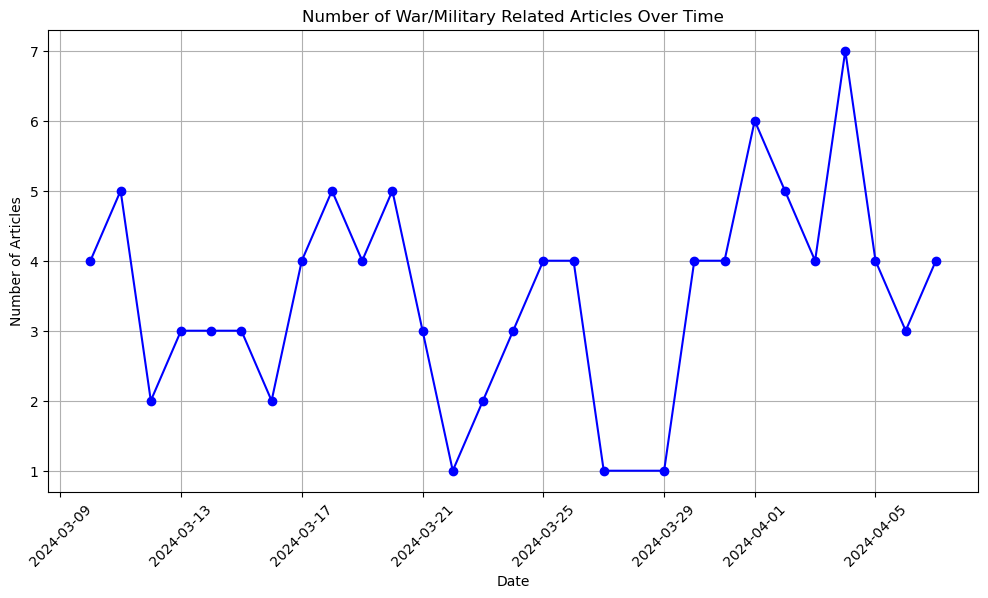

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert articles into a DataFrame
articles_data = [{'title': article['title'], 'publishedAt': article['publishedAt']} for article in c['articles']]
df_articles = pd.DataFrame(articles_data)

# Convert publishedAt to datetime and extract date
df_articles['publishedAt'] = pd.to_datetime(df_articles['publishedAt']).dt.date

# Count articles by date
article_counts = df_articles.groupby('publishedAt').size().reset_index(name='counts')

# Plot
plt.figure(figsize=(12, 6))
plt.plot(article_counts['publishedAt'], article_counts['counts'], marker='o', linestyle='-', color='b')
plt.title('Number of War/Military Related Articles Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

3. WEBSCRAPPING FROM WIKI

In [7]:
import requests
from bs4 import BeautifulSoup

# URL of the Wikipedia page
url = "https://en.wikipedia.org/wiki/List_of_wars:_2003–present"

# Send a GET request to the page
response = requests.get(url)

# Parse the HTML content
soup = BeautifulSoup(response.text, 'html.parser')

# Find the table(s) you're interested in by class or ID.
# Adjust 'wikitable' to the correct class name based on your inspection
tables = soup.find_all('table', class_='wikitable')

# List to hold all wars data
wars_data = []

# Go through all found tables
for table in tables:
    # Find all row tags in the table, skip the first one as it's usually the header
    for row in table.find_all('tr')[1:]:
        # Find all cell tags in the row
        cells = row.find_all('td')
        if cells:
            # Adjust the indexes below according to the actual table structure
            start_year = cells[0].text.strip()
            end_year = cells[1].text.strip()
            name_of_conflict = cells[2].text.strip()
            # There may be more cells with additional data. Append them as needed.
            
            # Append a tuple with all the extracted data for this row to the wars_data list
            wars_data.append((start_year, end_year, name_of_conflict))

# Now, print the collected wars data to see if we have successfully scraped anything
for war in wars_data:
    print(war)

# Assuming `wars_data` is your list of tuples containing the scraped data
df_wars = pd.DataFrame(wars_data, columns=['Start Year', 'End Year', 'Name of Conflict'])

# Clean the '\n' and any subsequent text from the 'Name of Conflict' column
df_wars['Name of Conflict'] = df_wars['Name of Conflict'].str.replace(r'\n.*', '', regex=True)

# Display the DataFrame to verify its format
print(df_wars)


('2003', '2020', 'War in Darfur')
('2003', '2011', 'Iraq War\nPart of the Iraqi conflict')
('2004', '2010', 'Sinaloa Cartel–Gulf Cartel conflict\nPart of the Mexican drug war')
('2004', 'Ongoing', 'South Thailand insurgency')
('2004', 'Ongoing', 'Insurgency in Khyber Pakhtunkhwa')
('2004', 'Ongoing', 'Iran–PJAK conflict\nPart of the Kurdish separatism in Iran')
('2004', 'Ongoing', 'Conflict in the Niger Delta')
('2004', 'Ongoing', 'Kivu conflict')
('2004', '2014', 'Houthi insurgency in Yemen')
('2004', '2007', 'Central African Republic Bush War')
('2004', 'Ongoing', 'Sistan and Baluchestan insurgency\nPart of the Balochistan conflict')
('2005', '2005', '2005 Bangladesh India border clash')
('2005', 'Ongoing', 'Insurgency in Paraguay')
('2005', '2010', 'Chadian Civil War (2005–2010)')
('2005', '2008', 'Mount Elgon insurgency')
('2006', 'Ongoing', 'Fatah–Hamas conflict')
('2006', '2008', 'Iraqi Civil War\nPart of the Iraq War')
('2006', '2013', 'Operation Astute')
('2006', '2009', 'Bakas

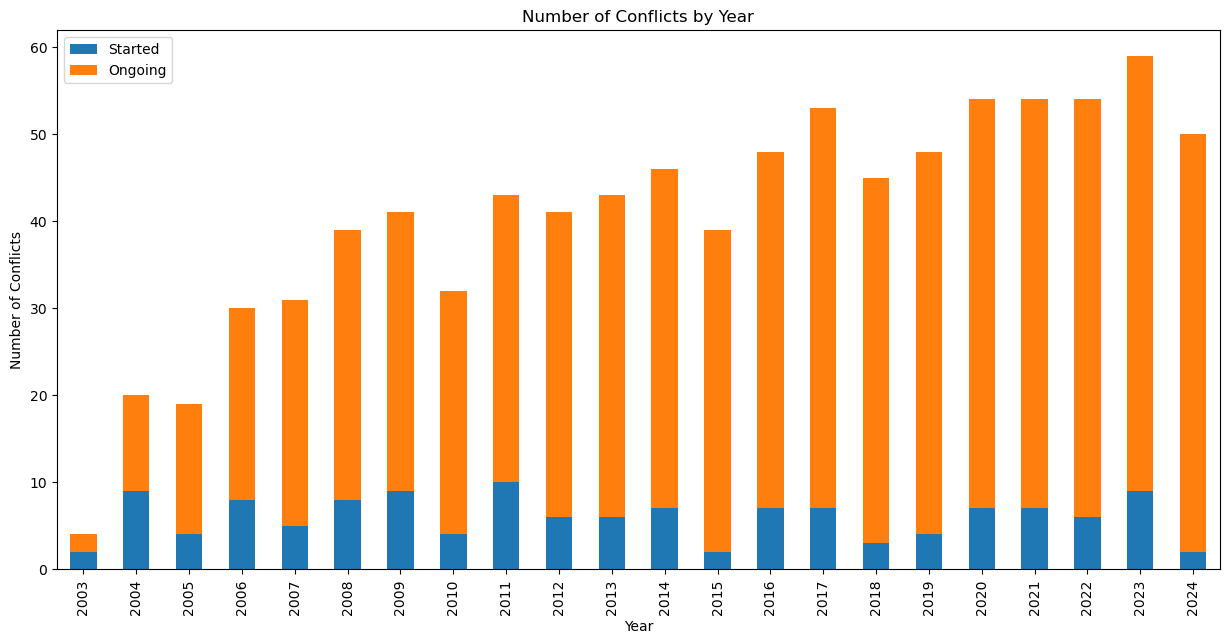

In [33]:
df_wars = pd.DataFrame(wars_data, columns=['Start Year', 'End Year', 'Name of Conflict'])

# Replace 'Ongoing' with the current year for ongoing conflicts
current_year = pd.to_datetime('now').year
df_wars['End Year'] = df_wars['End Year'].replace('Ongoing', current_year)

# Convert years to numeric
df_wars['Start Year'] = pd.to_numeric(df_wars['Start Year'])
df_wars['End Year'] = pd.to_numeric(df_wars['End Year'])

# Create a range of years from the earliest 'Start Year' to the current year
years = range(df_wars['Start Year'].min(), current_year + 1)

# Initialize a DataFrame to hold the count of started and ongoing conflicts per year
conflicts_per_year = pd.DataFrame(index=years, columns=['Started', 'Ongoing', 'Ended'])

# Count the number of conflicts that started, were ongoing, and ended each year
for year in years:
    conflicts_per_year.loc[year, 'Started'] = df_wars['Start Year'].eq(year).sum()
    conflicts_per_year.loc[year, 'Ongoing'] = df_wars[df_wars['Start Year'].le(year) & df_wars['End Year'].ge(year)].shape[0]
    conflicts_per_year.loc[year, 'Ended'] = df_wars['End Year'].eq(year).sum()

# Convert all counts to integers
conflicts_per_year = conflicts_per_year.astype(int)

# Plot the counts
conflicts_per_year[['Started', 'Ongoing']].plot(kind='bar', stacked=True, figsize=(15, 7))
plt.title('Number of Conflicts by Year')
plt.xlabel('Year')
plt.ylabel('Number of Conflicts')
plt.legend()
plt.show()

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
country_metadata = pd.read_csv('Metadata_Country_API_MS.MIL.XPND.CD_DS2_en_csv_v2_47475.csv')
expenditure_data = pd.read_csv('API_MS.MIL.XPND.CD_DS2_en_csv_v2_47475.csv', skiprows=4)

# Merge the DataFrames
merged_data = pd.merge(expenditure_data, country_metadata[['Country Code', 'IncomeGroup']], on='Country Code')

# Filter for years 2000 onwards
years = [str(year) for year in range(2003, 2023)]
merged_data = merged_data[['Country Code', 'IncomeGroup'] + years]

# Melt the data so that years are in a single column
melted_data = merged_data.melt(id_vars=['Country Code', 'IncomeGroup'], value_vars=years, var_name='Year', value_name='Expenditure')

# Group by IncomeGroup and Year and sum the Expenditures
grouped_data = melted_data.groupby(['IncomeGroup', 'Year']).sum().reset_index()

# Pivot the data for plotting
pivot_data = grouped_data.pivot(index='Year', columns='IncomeGroup', values='Expenditure')

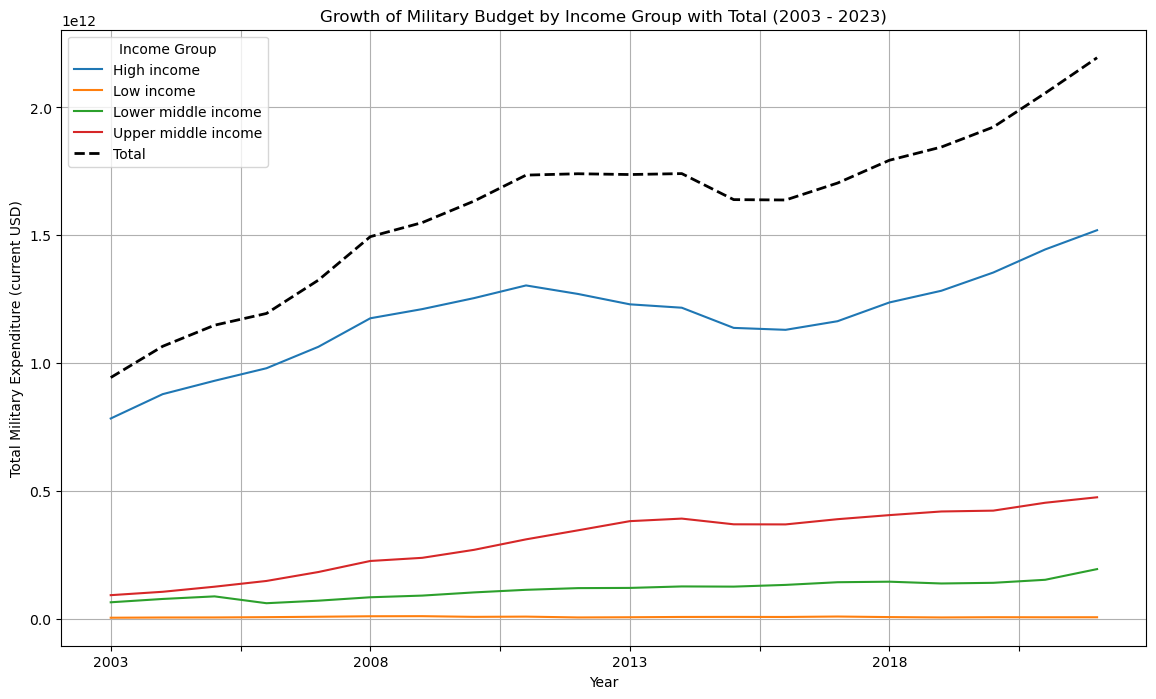

In [10]:
# Assuming 'pivot_data' is already created with each column representing an income group

# Calculate the total expenditure across all income groups for each year
pivot_data['Total'] = pivot_data.sum(axis=1)

# Plot the data with income group lines
ax = pivot_data.drop('Total', axis=1).plot(kind='line', figsize=(14, 8), legend=True)

# Add the 'Total' line to the existing plot
pivot_data['Total'].plot(ax=ax, color='black', linestyle='--', linewidth=2, legend=True)

# Final touches to the plot
plt.title('Growth of Military Budget by Income Group with Total (2003 - 2023)')
plt.xlabel('Year')
plt.ylabel('Total Military Expenditure (current USD)')
plt.grid(True)
plt.legend(title='Income Group')
plt.show()


In [11]:
# Example to aggregate mock conflict data to yearly
conflicts_per_year = df_wars['Start Year'].value_counts().sort_index()
conflicts_per_year.index = pd.to_numeric(conflicts_per_year.index)

In [12]:
# Ensure that 'Year' is a column in pivot_data
pivot_data.reset_index(inplace=True)

# Convert the 'Year' column to int for both DataFrames if it's not already
pivot_data['Year'] = pivot_data['Year'].astype(int)
conflicts_per_year = conflicts_per_year.reset_index()
conflicts_per_year['Start Year'] = conflicts_per_year['Start Year'].astype(int)

# Rename the columns in conflicts_per_year for clarity
conflicts_per_year.rename(columns={'Start Year': 'Year', 'count': 'Total Conflicts'}, inplace=True)

# Merge the DataFrames on 'Year'
summary_data = pd.merge(pivot_data, conflicts_per_year, how='left', left_on='Year', right_on='Year')

# Now you have a DataFrame that contains both military expenditure and conflicts count
print(summary_data.head())


   Year   High income    Low income  Lower middle income  Upper middle income  \
0  2003  7.832885e+11  3.831886e+09         6.421867e+10         9.207506e+10   
1  2004  8.784388e+11  4.676256e+09         7.723584e+10         1.053003e+11   
2  2005  9.308266e+11  4.868986e+09         8.734631e+10         1.251883e+11   
3  2006  9.798676e+11  6.025367e+09         6.060271e+10         1.476864e+11   
4  2007  1.063769e+12  7.650629e+09         7.051495e+10         1.826545e+11   

          Total  Total Conflicts  
0  9.434141e+11                2  
1  1.065651e+12                9  
2  1.148230e+12                4  
3  1.194182e+12                8  
4  1.324589e+12                5  


/Users/mariiaboiko/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


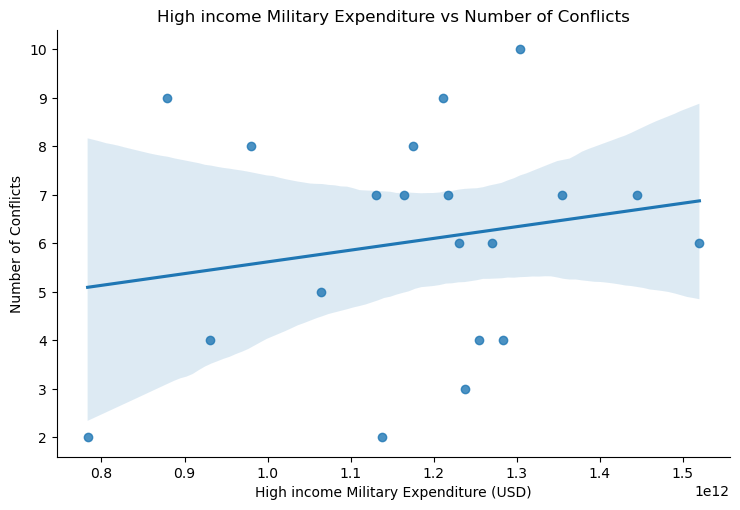

/Users/mariiaboiko/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


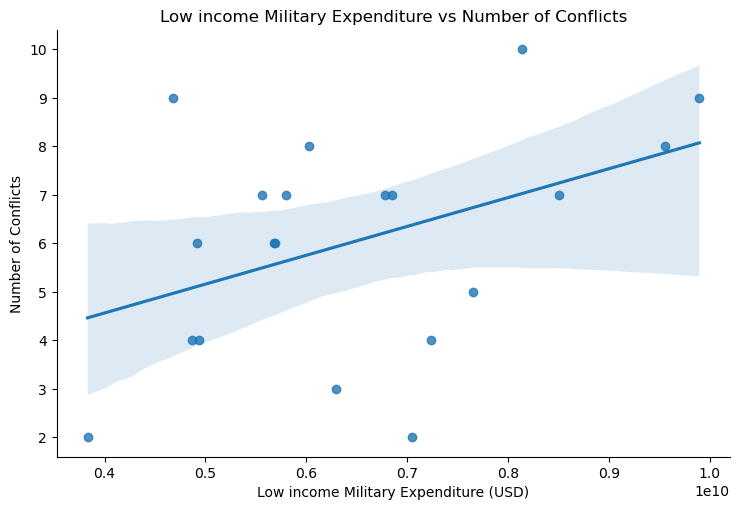

/Users/mariiaboiko/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


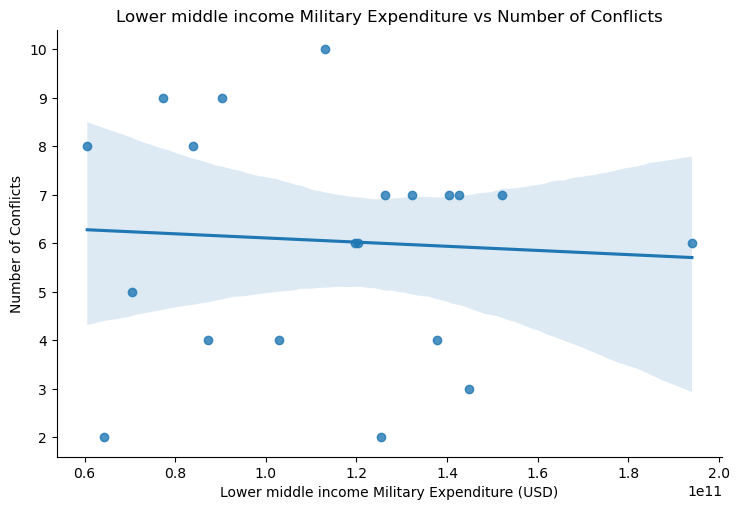

/Users/mariiaboiko/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


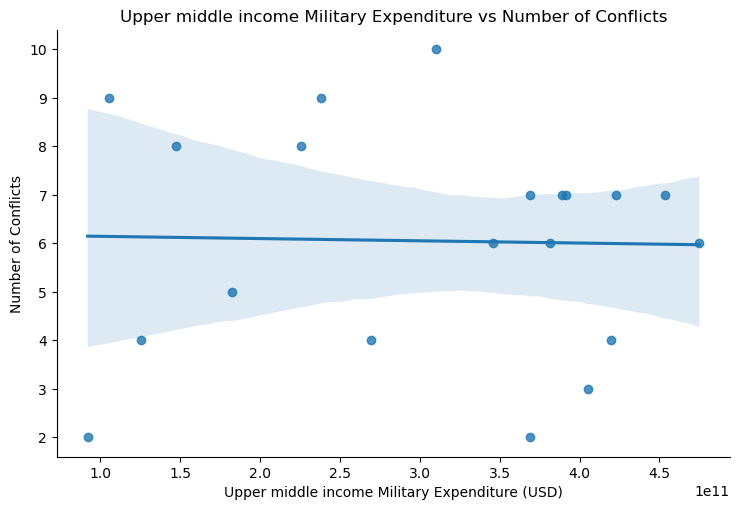

In [20]:
import seaborn as sns

# Create a scatter plot with regression line for each income group
income_groups = ['High income', 'Low income', 'Lower middle income', 'Upper middle income']
for group in income_groups:
    sns.lmplot(x=group, y='Total Conflicts', data=summary_data, aspect=1.5)
    plt.xlabel(f'{group} Military Expenditure (USD)')
    plt.ylabel('Number of Conflicts')
    plt.title(f'{group} Military Expenditure vs Number of Conflicts')
    plt.show()


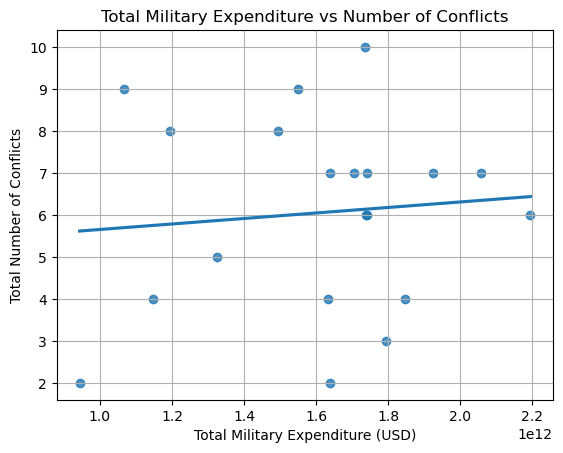

In [21]:
sns.regplot(x='Total', y='Total Conflicts', data=summary_data, ci=None)

plt.title('Total Military Expenditure vs Number of Conflicts')
plt.xlabel('Total Military Expenditure (USD)')
plt.ylabel('Total Number of Conflicts')
plt.grid(True)
plt.show()

[*********************100%%**********************]  3 of 3 completed


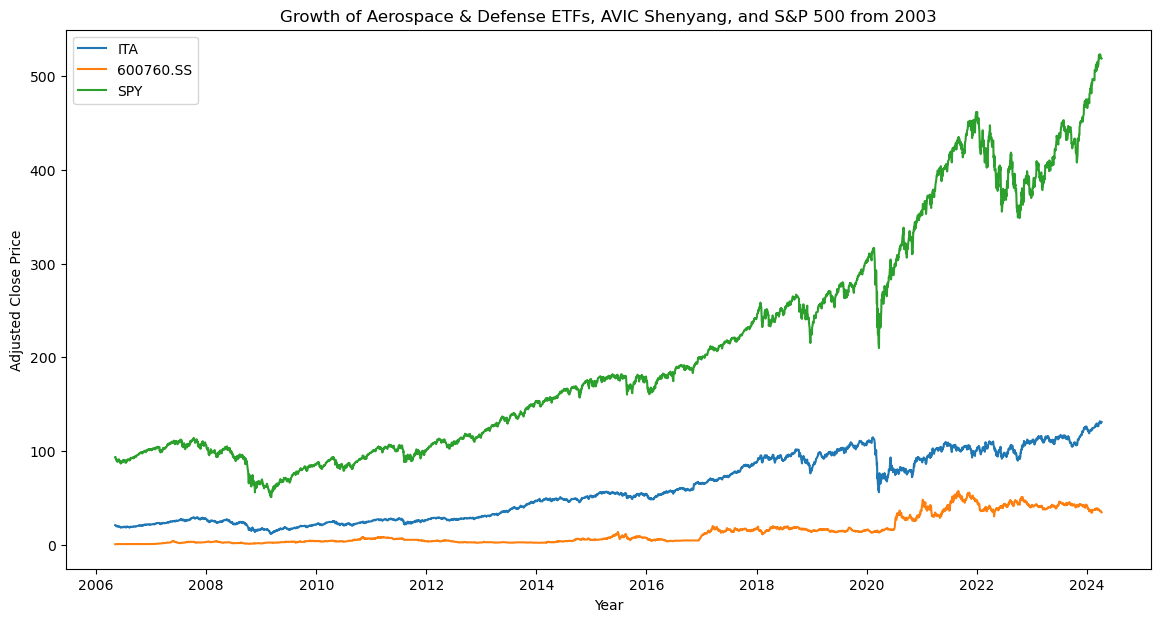

In [15]:
import yfinance as yf
import matplotlib.pyplot as plt

# Define the tickers for the ETFs and the company, including the S&P 500 ETF
tickers = ['ITA', '600760.SS', 'SPY']

# Fetch historical data for each ETF and company from 2003 onwards
etf_data = yf.download(tickers, start="2003-01-01")['Adj Close']

# Check for any missing data and drop those rows
etf_data = etf_data.dropna()

# Plot the growth of the ETFs, company, and S&P 500 over time
plt.figure(figsize=(14, 7))
for ticker in tickers:
    if ticker in etf_data.columns:  # Check if the ticker data is available
        plt.plot(etf_data.index, etf_data[ticker], label=ticker)

plt.title('Growth of Aerospace & Defense ETFs, AVIC Shenyang, and S&P 500 from 2003')
plt.xlabel('Year')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed


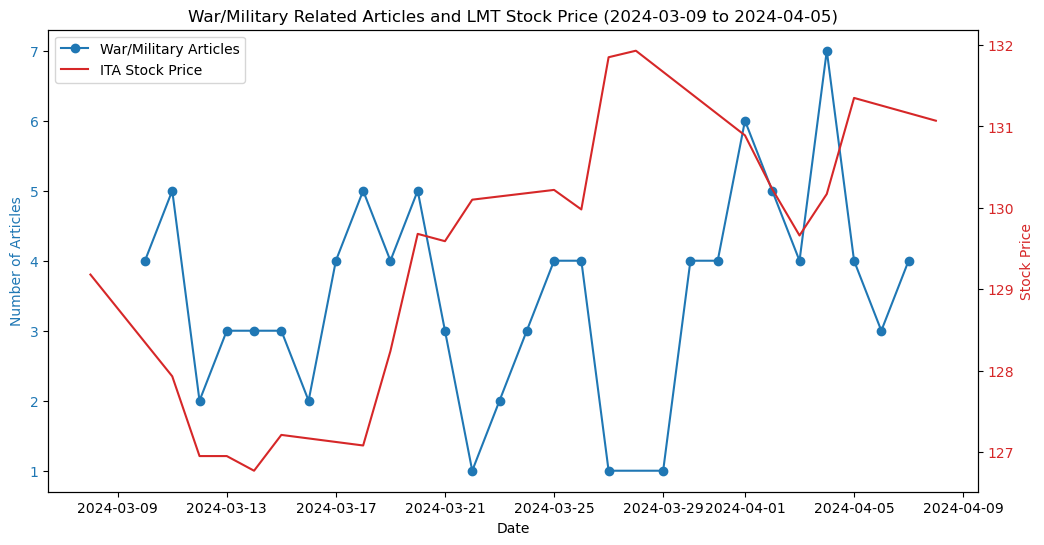

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Assuming 'c' contains the articles as previously defined
# You already have df_articles and article_counts prepared

# Fetch stock price data for a company, say Lockheed Martin (LMT), for the specified period
us_fund = yf.download('ITA', start='2024-03-08')

# Reset index to make 'Date' a column
us_fund.reset_index(inplace=True)

# Convert 'Date' to datetime.date for consistency with df_articles
us_fund['Date'] = pd.to_datetime(us_fund['Date']).dt.date

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot article counts
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Articles', color=color)
ax1.plot(article_counts['publishedAt'], article_counts['counts'], color=color, marker='o', linestyle='-', label='War/Military Articles')
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  

# Plot stock price
color = 'tab:red'
ax2.set_ylabel('Stock Price', color=color)
ax2.plot(us_fund['Date'], us_fund['Close'], color=color, label='ITA Stock Price')
ax2.tick_params(axis='y', labelcolor=color)

# Combined legend for both lines
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('War/Military Related Articles and LMT Stock Price (2024-03-09 to 2024-04-05)')
plt.show()

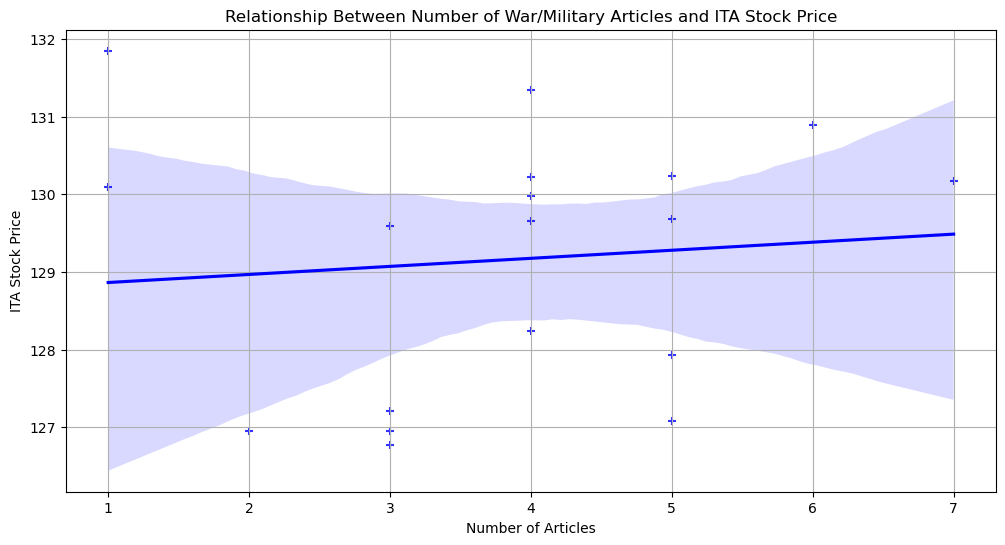

In [22]:
# Rename 'publishedAt' column in article_counts to 'Date' for consistent merging
article_counts.rename(columns={'publishedAt': 'Date'}, inplace=True)

# Ensure 'Date' columns in both DataFrames are in the same format
us_fund['Date'] = pd.to_datetime(us_fund['Date'])
article_counts['Date'] = pd.to_datetime(article_counts['Date'])

# Merge the DataFrames on 'Date'
merged_data = pd.merge(us_fund, article_counts, how='left', on='Date')

# Plotting the scatterplot with Regression Line
plt.figure(figsize=(12, 6))
sns.regplot(x='counts', y='Close', data=merged_data, color='blue', marker='+')
plt.title('Relationship Between Number of War/Military Articles and ITA Stock Price')
plt.xlabel('Number of Articles')
plt.ylabel('ITA Stock Price')
plt.grid(True)
plt.show()


In [19]:
from scipy.stats import ttest_ind

# Step 1: Calculate the median number of articles
median_articles = merged_data['counts'].median()

# Step 2: Categorize days based on the median
merged_data['Article_Level'] = ['High' if x > median_articles else 'Low' for x in merged_data['counts']]

# Step 3: Separate the stock prices into two groups based on article level
high_articles_stock_prices = merged_data[merged_data['Article_Level'] == 'High']['Close']
low_articles_stock_prices = merged_data[merged_data['Article_Level'] == 'Low']['Close']

# Run the t-test
t_stat, p_value = ttest_ind(high_articles_stock_prices.dropna(), low_articles_stock_prices.dropna(), equal_var=False)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -0.09568018339756047, P-value: 0.9254608433741867
Ticker      600760.SS         ITA         SPY
Date                                         
2006-05-08   0.831403   21.180216   93.710426
2006-05-09   0.856296   21.159771   93.894501
2006-05-10   0.856296   21.257931   93.844910
2006-05-11   0.856296   21.020693   92.712105
2006-05-12   0.881188   20.570753   91.501457
...               ...         ...         ...
2024-03-28  36.490002  131.929993  523.070007
2024-04-01  36.349998  130.889999  522.159973
2024-04-02  35.700001  130.229996  518.840027
2024-04-03  35.720001  129.660004  519.409973
2024-04-08  34.869999  131.070007  518.719971

[4217 rows x 3 columns]


In [30]:
print(etf_data)
print(pivot_data)
print(conflicts_per_year)
print(summary_data)

Ticker      600760.SS         ITA         SPY  Year
Date                                               
2006-05-08   0.831403   21.180216   93.710426  2006
2006-05-09   0.856296   21.159771   93.894501  2006
2006-05-10   0.856296   21.257931   93.844910  2006
2006-05-11   0.856296   21.020693   92.712105  2006
2006-05-12   0.881188   20.570753   91.501457  2006
...               ...         ...         ...   ...
2024-03-28  36.490002  131.929993  523.070007  2024
2024-04-01  36.349998  130.889999  522.159973  2024
2024-04-02  35.700001  130.229996  518.840027  2024
2024-04-03  35.720001  129.660004  519.409973  2024
2024-04-08  34.869999  131.070007  518.719971  2024

[4217 rows x 4 columns]
IncomeGroup  Year   High income    Low income  Lower middle income  \
0            2003  7.832885e+11  3.831886e+09         6.421867e+10   
1            2004  8.784388e+11  4.676256e+09         7.723584e+10   
2            2005  9.308266e+11  4.868986e+09         8.734631e+10   
3            2006  

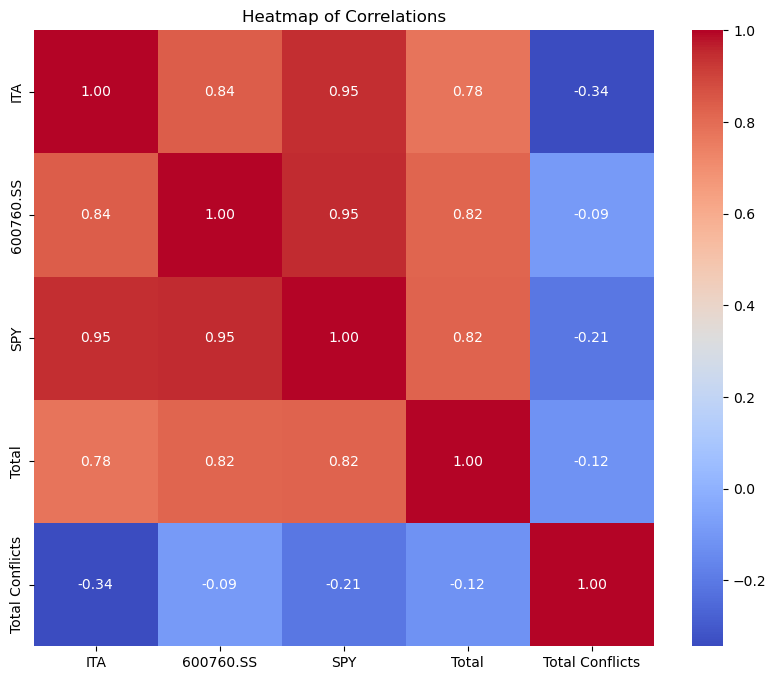

In [25]:
from scipy.stats import linregress

# Ensure etf_data has a 'Year' column
etf_data['Year'] = pd.to_datetime(etf_data.index).year

# Average ETF and SPY data by year to simplify
etf_yearly_avg = etf_data.groupby('Year').mean()

# Merge the yearly average ETF data with pivot_data (expenditure) and conflicts_per_year
combined_data = pd.merge(etf_yearly_avg, pivot_data, on='Year')
combined_data = pd.merge(combined_data, conflicts_per_year, on='Year')

# Assuming you're interested in 'ITA' and 'SPY' prices, along with 'Total' expenditure and 'Total Conflicts'
interest_cols = ['ITA', '600760.SS', 'SPY', 'Total', 'Total Conflicts']
heatmap_data = combined_data[interest_cols]

# Calculate correlations
corr_matrix = heatmap_data.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Correlations')
plt.show()

In [26]:
import statsmodels.api as sm

# Ensure that 'Total Conflicts' and the stock prices are numeric and not missing any values
combined_data['Total Conflicts'] = pd.to_numeric(combined_data['Total Conflicts'], errors='coerce').fillna(0)
combined_data['ITA'] = pd.to_numeric(combined_data['ITA'], errors='coerce').fillna(0)
combined_data['600760.SS'] = pd.to_numeric(combined_data['600760.SS'], errors='coerce').fillna(0)

# Prepare the independent variables (add a constant term to allow the intercept to be fitted)
X = sm.add_constant(combined_data['Total Conflicts'])

# Prepare the dependent variables
y_ITA = combined_data['ITA']
y_600760_SS = combined_data['600760.SS']

# Fit the model for ITA
model_ITA = sm.OLS(y_ITA, X).fit()

# Fit the model for 600760.SS
model_600760_SS = sm.OLS(y_600760_SS, X).fit()

# Print the summaries to see the results
print("ITA Regression Analysis")
print(model_ITA.summary())
print("\n600760.SS Regression Analysis")
print(model_600760_SS.summary())


ITA Regression Analysis
                            OLS Regression Results                            
Dep. Variable:                    ITA   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     2.010
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.177
Time:                        08:34:04   Log-Likelihood:                -81.555
No. Observations:                  17   AIC:                             167.1
Df Residuals:                      15   BIC:                             168.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             

/Users/mariiaboiko/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/mariiaboiko/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [27]:
import statsmodels.api as sm

# Assuming 'combined_data' is prepared and includes 'Year', 'ITA', '600760.SS', and 'Started' conflicts

# Convert 'Started' conflicts to numeric
combined_data['Started'] = pd.to_numeric(combined_data['Started'], errors='coerce').fillna(0)

# Prepare the independent variables (add a constant term to allow the intercept to be fitted)
X_started = sm.add_constant(combined_data['Started'])

# Prepare the dependent variables as before
y_ITA = combined_data['ITA']
y_600760_SS = combined_data['600760.SS']

# Fit the model for ITA with 'Started' conflicts
model_ITA_started = sm.OLS(y_ITA, X_started).fit()

# Fit the model for 600760.SS with 'Started' conflicts
model_600760_SS_started = sm.OLS(y_600760_SS, X_started).fit()

# Print the summaries to see the results
print("ITA Regression Analysis with Started Conflicts")
print(model_ITA_started.summary())
print("\n600760.SS Regression Analysis with Started Conflicts")
print(model_600760_SS_started.summary())


KeyError: 'Started'

In [28]:
print(combined_data)

    Year  600760.SS         ITA         SPY   High income    Low income  \
0   2006   0.990901   20.167412   94.175467  9.798676e+11  6.025367e+09   
1   2007   2.515090   25.780208  106.826936  1.063769e+12  7.650629e+09   
2   2008   2.420558   22.510680   89.758359  1.175363e+12  9.555957e+09   
3   2009   3.235031   17.766577   72.015439  1.211216e+12  9.898678e+09   
4   2010   4.894442   23.157117   88.235069  1.254323e+12  7.232615e+09   
5   2011   6.401630   26.075286  100.079875  1.303829e+12  8.141083e+09   
6   2012   3.562358   28.184765  111.119730  1.270537e+12  4.920915e+09   
7   2013   2.739216   37.586767  135.637353  1.229915e+12  5.681351e+09   
8   2014   4.269653   48.813567  162.338270  1.216667e+12  6.850828e+09   
9   2015   7.944005   54.014797  176.432218  1.137733e+12  7.050864e+09   
10  2016   5.096049   57.501019  183.271958  1.130175e+12  6.778173e+09   
11  2017  15.584464   75.755464  218.424950  1.163831e+12  8.507514e+09   
12  2018  17.127973   92.

In [36]:
# Ensure df_wars['Start Year'] is an integer
df_wars['Start Year'] = pd.to_numeric(df_wars['Start Year'], errors='coerce').fillna(0).astype(int)

# Summarize the number of started conflicts per year
started_conflicts_per_year = df_wars.groupby('Start Year').size().reset_index(name='Started Conflicts')
print(started_conflicts_per_year)

    Start Year  Started Conflicts
0         2003                  2
1         2004                  9
2         2005                  4
3         2006                  8
4         2007                  5
5         2008                  8
6         2009                  9
7         2010                  4
8         2011                 10
9         2012                  6
10        2013                  6
11        2014                  7
12        2015                  2
13        2016                  7
14        2017                  7
15        2018                  3
16        2019                  4
17        2020                  7
18        2021                  7
19        2022                  6
20        2023                  9
21        2024                  2


In [38]:
print(etf_data)

Ticker      600760.SS         ITA         SPY  Year
Date                                               
2006-05-08   0.831403   21.180216   93.710426  2006
2006-05-09   0.856296   21.159771   93.894501  2006
2006-05-10   0.856296   21.257931   93.844910  2006
2006-05-11   0.856296   21.020693   92.712105  2006
2006-05-12   0.881188   20.570753   91.501457  2006
...               ...         ...         ...   ...
2024-03-28  36.490002  131.929993  523.070007  2024
2024-04-01  36.349998  130.889999  522.159973  2024
2024-04-02  35.700001  130.229996  518.840027  2024
2024-04-03  35.720001  129.660004  519.409973  2024
2024-04-08  34.869999  131.070007  518.719971  2024

[4217 rows x 4 columns]


In [40]:
# Summarize ETF data by year if not already summarized
yearly_etf_data = etf_data.groupby('Year').mean()

# Merge started conflicts with ETF data
analysis_data = pd.merge(yearly_etf_data, started_conflicts_per_year, left_on='Year', right_on='Started Conflicts', how='outer')

# Merge the above with military expenditure (pivot_data assumed to be already yearly and contains a 'Year' column)
final_data = pd.merge(analysis_data, pivot_data, on='Year', how='outer')

KeyError: 'Year'

In [41]:
# Ensure 'Year' in yearly_etf_data is of integer type
yearly_etf_data.reset_index(inplace=True)
yearly_etf_data['Year'] = yearly_etf_data['Year'].astype(int)

# Correct the merging of started conflicts with ETF data
analysis_data = pd.merge(yearly_etf_data, started_conflicts_per_year, left_on='Year', right_on='Start Year', how='outer')


In [49]:
# Assuming pivot_data is already prepared correctly and contains 'Year' as a column
pivot_data['Year'] = pivot_data['Year'].astype(int)
print(pivot_data)
print(analysis_data)

IncomeGroup  Year   High income    Low income  Lower middle income  \
0            2003  7.832885e+11  3.831886e+09         6.421867e+10   
1            2004  8.784388e+11  4.676256e+09         7.723584e+10   
2            2005  9.308266e+11  4.868986e+09         8.734631e+10   
3            2006  9.798676e+11  6.025367e+09         6.060271e+10   
4            2007  1.063769e+12  7.650629e+09         7.051495e+10   
5            2008  1.175363e+12  9.555957e+09         8.385515e+10   
6            2009  1.211216e+12  9.898678e+09         9.039465e+10   
7            2010  1.254323e+12  7.232615e+09         1.029150e+11   
8            2011  1.303829e+12  8.141083e+09         1.130176e+11   
9            2012  1.270537e+12  4.920915e+09         1.196333e+11   
10           2013  1.229915e+12  5.681351e+09         1.204480e+11   
11           2014  1.216667e+12  6.850828e+09         1.262249e+11   
12           2015  1.137733e+12  7.050864e+09         1.254969e+11   
13           2016  1

In [52]:
final_data = pd.merge(analysis_data, pivot_data, on='Year', how='outer')

In [53]:
print(final_data)

      Year  600760.SS         ITA         SPY  Start Year  Started Conflicts  \
0   2006.0   0.990901   20.167412   94.175467      2006.0                8.0   
1   2007.0   2.515090   25.780208  106.826936      2007.0                5.0   
2   2008.0   2.420558   22.510680   89.758359      2008.0                8.0   
3   2009.0   3.235031   17.766577   72.015439      2009.0                9.0   
4   2010.0   4.894442   23.157117   88.235069      2010.0                4.0   
5   2011.0   6.401630   26.075286  100.079875      2011.0               10.0   
6   2012.0   3.562358   28.184765  111.119730      2012.0                6.0   
7   2013.0   2.739216   37.586767  135.637353      2013.0                6.0   
8   2014.0   4.269653   48.813567  162.338270      2014.0                7.0   
9   2015.0   7.944005   54.014797  176.432218      2015.0                2.0   
10  2016.0   5.096049   57.501019  183.271958      2016.0                7.0   
11  2017.0  15.584464   75.755464  218.4

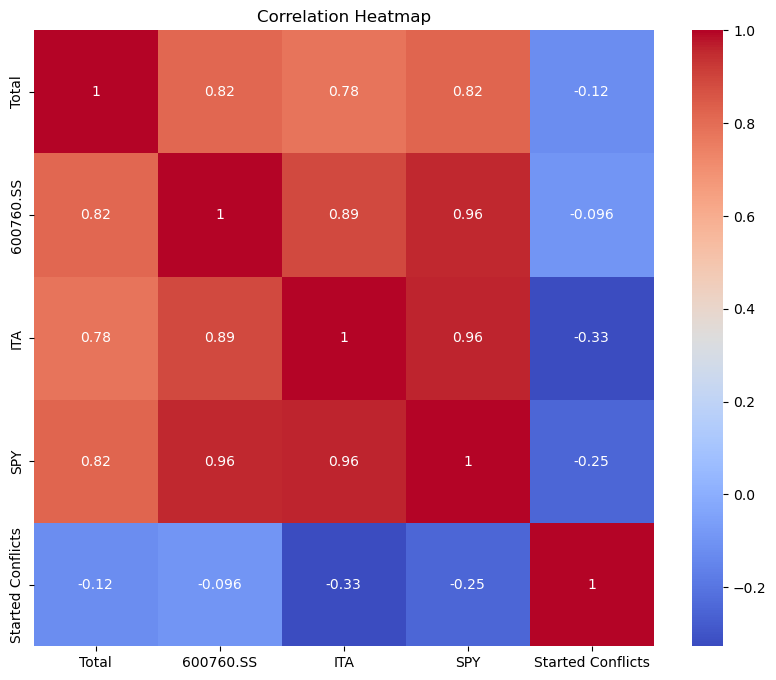

In [56]:
# Calculate correlation matrix for final_data
final_data2 = final_data[['Total', '600760.SS', 'ITA', 'SPY', 'Started Conflicts']]
correlation_matrix = final_data2.corr()

# Plot heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [61]:
import statsmodels.api as sm

# Preparing data for regression (ITA as dependent variable)
X = final_data[['High income', 'Started Conflicts', 'SPY']]  # Independent variables
X = sm.add_constant(X)  # Adds a constant term to the predictor
y_ita = final_data2['ITA']  # Dependent variable

# Running the regression
model_ita = sm.OLS(y_ita, X, missing='drop').fit()  # 'drop' option excludes NaNs

# Displaying the regression results
print(model_ita.summary())

                            OLS Regression Results                            
Dep. Variable:                    ITA   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     52.11
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           1.67e-07
Time:                        09:42:10   Log-Likelihood:                -60.805
No. Observations:                  17   AIC:                             129.6
Df Residuals:                      13   BIC:                             132.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                41.2613     29.48

/Users/mariiaboiko/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


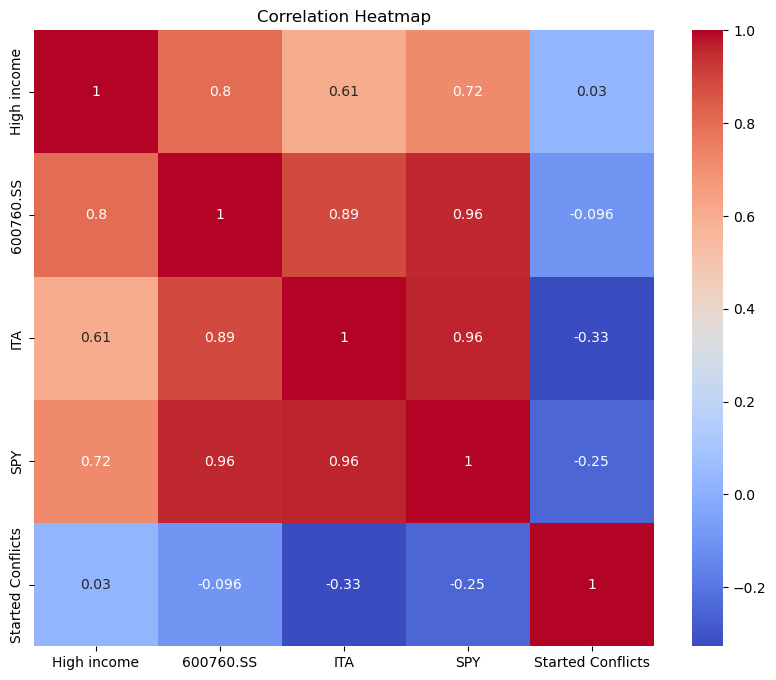

In [60]:
# Calculate correlation matrix for final_data
#final_data2 = final_data[['High income', '600760.SS', 'ITA', 'SPY', 'Started Conflicts']]
correlation_matrix = final_data[['High income', '600760.SS', 'ITA', 'SPY', 'Started Conflicts']].corr()

# Plot heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

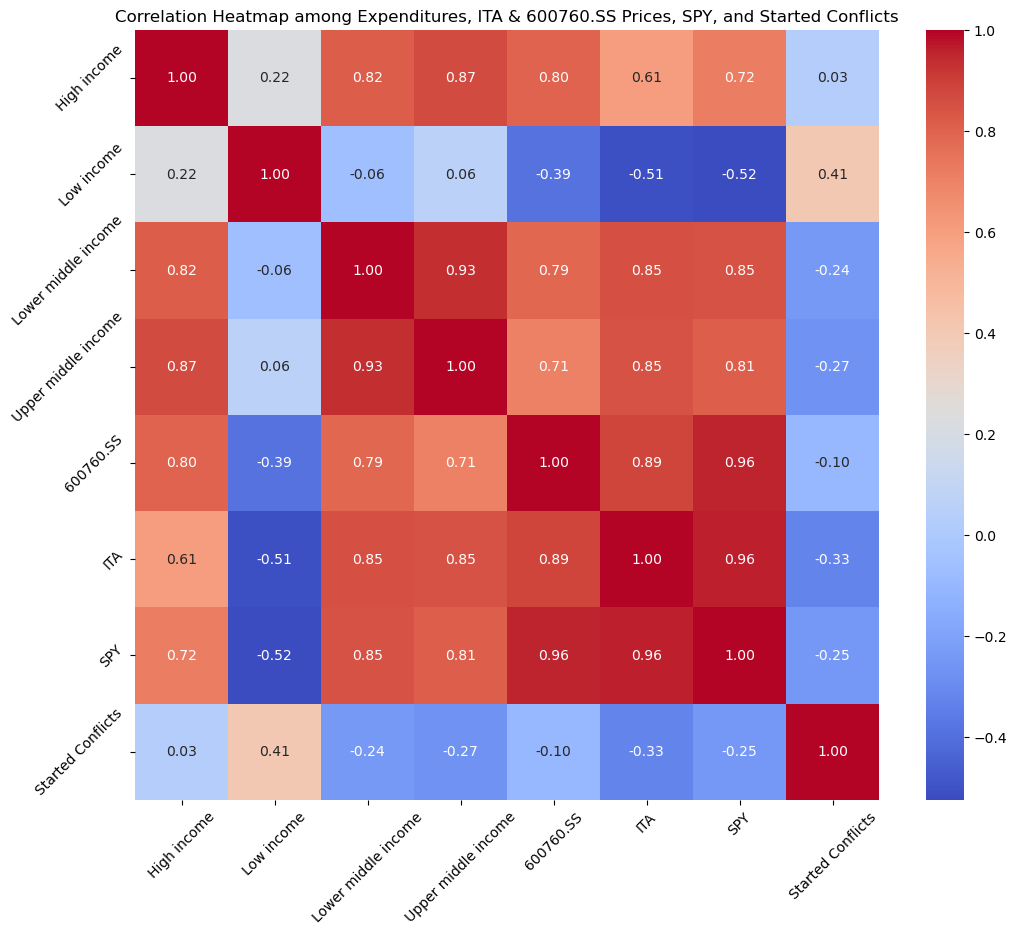

In [62]:
# Assuming final_data includes necessary columns
final_data2 = final_data[['High income', 'Low income', 'Lower middle income', 'Upper middle income', '600760.SS', 'ITA', 'SPY', 'Started Conflicts']]

# Calculate correlation matrix
correlation_matrix = final_data2.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))  # Adjust size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap among Expenditures, ITA & 600760.SS Prices, SPY, and Started Conflicts')
plt.xticks(rotation=45)  # Improves readability of x-axis labels
plt.yticks(rotation=45)  # Improves readability of y-axis labels
plt.show()


In [63]:
import statsmodels.api as sm

# Function to run regression for a given income group and print results
def run_regression(data, income_group):
    # Define the predictor (independent variable) and response (dependent variable)
    X = data[income_group]  # Military expenditure for the income group
    y = data['Started Conflicts']  # Number of started conflicts
    
    # Add a constant to the predictor (statsmodels does not add it by default)
    X = sm.add_constant(X)
    
    # Fit the regression model
    model = sm.OLS(y, X, missing='drop').fit()  # 'drop' to ignore missing values
    
    # Print the summary of the regression
    print(f"Regression Results for {income_group} Income Group:")
    print(model.summary())
    print("\n")

# Assuming final_data is your DataFrame
income_groups = ['High income', 'Low income', 'Lower middle income', 'Upper middle income']

for group in income_groups:
    run_regression(final_data, group)


Regression Results for High income Income Group:
                            OLS Regression Results                            
Dep. Variable:      Started Conflicts   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.066
Method:                 Least Squares   F-statistic:                   0.01356
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.909
Time:                        09:44:53   Log-Likelihood:                -36.272
No. Observations:                  17   AIC:                             76.54
Df Residuals:                      15   BIC:                             78.21
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
c

/Users/mariiaboiko/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/mariiaboiko/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/mariiaboiko/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/mariiaboiko/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [64]:
import statsmodels.api as sm

# For ITA against each income group's military expenditure
income_groups = ['High income', 'Low income', 'Lower middle income', 'Upper middle income']

# Run regression for ITA
print("ITA Regression Results:")
for group in income_groups:
    X = final_data[group]  # Predictor
    y = final_data['ITA']  # Response
    X = sm.add_constant(X)  # Adds a constant term to the predictor
    model = sm.OLS(y, X, missing='drop').fit()  # OLS regression, excluding NaNs
    print(f"\n{group}:")
    print(model.summary())

# Run regression for 600760.SS
print("\n600760.SS Regression Results:")
for group in income_groups:
    X = final_data[group]  # Predictor
    y = final_data['600760.SS']  # Response
    X = sm.add_constant(X)  # Adds a constant term to the predictor
    model = sm.OLS(y, X, missing='drop').fit()  # OLS regression, excluding NaNs
    print(f"\n{group}:")
    print(model.summary())


ITA Regression Results:

High income:
                            OLS Regression Results                            
Dep. Variable:                    ITA   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     8.660
Date:                Tue, 09 Apr 2024   Prob (F-statistic):             0.0101
Time:                        09:47:38   Log-Likelihood:                -78.750
No. Observations:                  17   AIC:                             161.5
Df Residuals:                      15   BIC:                             163.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       

/Users/mariiaboiko/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/mariiaboiko/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/mariiaboiko/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/mariiaboiko/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/mariiaboiko/anaconda3/lib/python3.11/site-packages/scipy/stats/_s

In [65]:
import statsmodels.formula.api as smf

# Example regression for ITA prices
# Prepare your formula string based on your independent variables
formula_str = 'ITA ~ Q("High income") + Q("Low income") + Q("Lower middle income") + Q("Upper middle income") + SPY + Q("Started Conflicts")'

# Run OLS regression
model = smf.ols(formula=formula_str, data=final_data).fit()

# Print the summary results
print(model.summary())

# For 600760.SS, simply replace 'ITA' with '600760.SS' in the formula string and rerun


                            OLS Regression Results                            
Dep. Variable:                    ITA   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     31.17
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           6.49e-06
Time:                        09:52:26   Log-Likelihood:                -57.288
No. Observations:                  17   AIC:                             128.6
Df Residuals:                      10   BIC:                             134.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

/Users/mariiaboiko/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
